In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import vaderSentiment
warnings.filterwarnings('ignore')

Importando todas as bibliotecas incluindo o pacote do modelo que vou utilizar para análise de sentimentos, o VADER

In [ ]:
train=pd.read_csv('train.csv')

Dando uma olhada nos dados

In [ ]:
train.drop(['Description','RescuerID'],axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,2,2,1,1,100,41326,0,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,3,1,1,0,41401,0,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,2,1,1,0,41326,0,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,2,1,1,150,41401,0,5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,2,2,1,1,0,41326,0,850a43f90,3.0,2


Agora checar se tem algum dado faltando, algum "buraco" na base de dados.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

A coluna de descrição tem alguns dados faltando, precisamos lidar com isso já que essa é a coluna que vai servir para a análise de sentimentos

Porém, antes gostaria de checar a velocidade de adoção da base de dados que estamos utilizando

0 - Animal foi adotado no mesmo dia que foi colocado para adoção.

1 - Animal foi adotado entre 1 e 7 dias, na primeira semana em que foi colocado para adoção.

2 - Animal foi adota entre 8 e 30 dias, no primeiro mês em que foi colocado para adoção.

3 - Animal foi adota entre 31 e 90 dias, meses 2 e 3 desde que foi colocado para adoção.

4 - Não foi adotado após 100 dias (nessa base não tem nenhum animal que está na espera entre 90 e 100 dias).

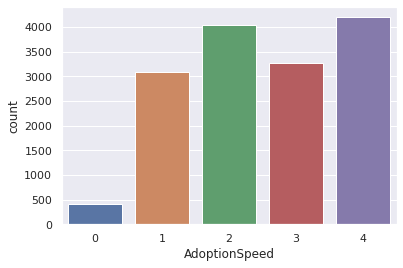

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="AdoptionSpeed", data=train)

Para analisar os sentimentos, utilizamos o VADER sentiment analysis package. A maioria das descrições é positiva ou neutra e as chances de ser adotado são maiores se a descrição for positiva.

O que é **análise de sentimentos**?

Análise de sentimentos é quando de forma computacional existe a tentativa de identificar e categorizar opiniões expressas em um texto, especialmente para determinar se o autor do texto estava sendo positivo, negativo ou neutro.

In [ ]:
train['Description'].fillna('none',inplace=True)

Ver um exemplo de como foi feita a descrição

In [ ]:
train['Description'][0]

"Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care."

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
i=0
petanalysis=[]
while i<train.shape[0]:
    dict1=sentiment_analyzer_scores(train['Description'][i])
    dict1.update({'PetID':train['PetID'][i]})
    petanalysis.append(dict1)
    i=i+1

In [ ]:
df=pd.DataFrame(petanalysis)

In [ ]:
train_2=train.merge(df,on='PetID',how='inner')

In [ ]:
train_2.loc[:,['compound','neg','pos','neu','Description']].head()

,compound,neg,pos,neu,Description
0,0.9552,0.000,0.239,0.761,Nibble is a 3+ month old ball of cuteness. He ...
1,0.1280,0.138,0.119,0.743,I just found it alone yesterday near my apartm...
2,0.7650,0.094,0.197,0.709,Their pregnant mother was dumped by her irresp...
3,0.9538,0.000,0.517,0.483,"Good guard dog, very alert, active, obedience ..."
4,0.9880,0.000,0.348,0.652,This handsome yet cute boy is up for adoption....


In [ ]:
train_2['compound'].describe()


count    14993.000000
mean         0.701029
std          0.376840
min         -0.981600
25%          0.588800
50%          0.875000
75%          0.957800
max          0.999700
Name: compound, dtype: float64

Vamos dar uma olhada na descrição mais negativa.

In [ ]:
train_2.loc[train_2['compound']==-.981600,['Description']].values

array([['Meet Baby Rosemary, one of the puppies that we intend to rescue out from the area where they hv been seeking shelter since born - longkang near the surau. We recently found out that the timid mummy that we have been feeding actually gave birth to 7 puppies, but roughly 2 weeks ago, one heartless human being took one stick & jolok the hole near longkang where the puppies have been seeking refuge. And with that 3 was killed. Such a sad thing isnt that such hatred still exist? Why have to kill these innocent puppies? Moving on, we hope to get the 2 remaining puppies soon. They are kinda protective & barks loudly when touch. Who doesnt if they are subject to constant harassment & abuse like the dead siblings, rite?']],
      dtype=object)

E a velocidade de adoção desse animal.

In [ ]:
train_2.loc[train_2['compound']==-.981600,['AdoptionSpeed']].values

array([[2]])

Se pararmos para ler com calma, podemos ver que no texto tem várias palavras negativas, não necessariamente relacionadas ao animal mas que acabam por alterar o resultado.

Vamos olhar para descrições com nota positiva.

In [ ]:
train_2.loc[train_2['compound']>=.957800,['Description']].values

array([["This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie."],
       ['Peanut was an abused puppy until he was rescued. He was very scared of people but now he is a very happy and active puppy! He is a really loving puppy now. (: Lester Jenny Will you adopt him? ================================================== Adopters are required to vaccinate and neuter them. =================================================='],
       ["Hi Pet Lovers! This is my first posting and I need help! 3 months ago we befriended a mother stray cat with 3 kittens in our area and we 'adopted' them but they come and go as they please. 2 months ago the mother gave birth to a l

Agora a velocidade de adoção dos positivos.

In [ ]:
train_2.loc[train_2['compound']>.955700,['AdoptionSpeed']].values

array([[2],
       [1],
       [2],
       ...,
       [3],
       [4],
       [3]])

Text(0, 0.5, 'Density')

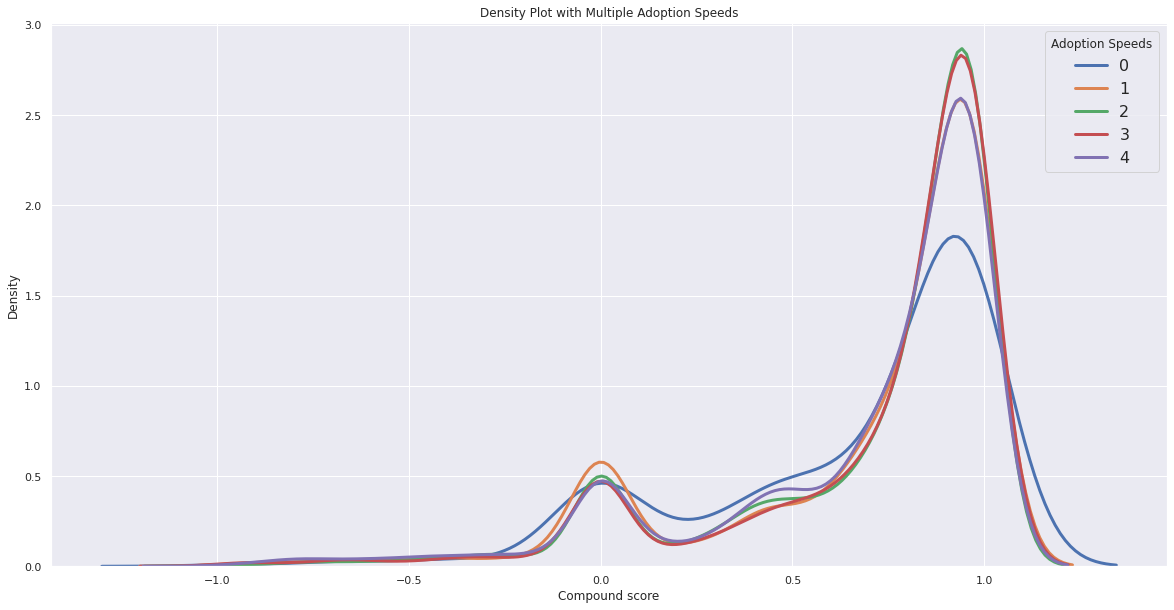

In [ ]:
plt.figure(figsize=(20,10))
speed = [0,1,2,3,4]

for i in speed:

    subset = train_2[(train_2['AdoptionSpeed'] == i)]
    

    sns.distplot(subset['compound'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i)
    

plt.legend(prop={'size': 16}, title = 'Adoption Speeds')
plt.title('Density Plot with Multiple Adoption Speeds')
plt.xlabel('Compound score')
plt.ylabel('Density')

Podemos esperar que a maioria do conteúdo escrito na coluna de descrições seja positivo. No gráfico conseguimos ver dois picos, um próximo do 0 (neutro) e outro próximo do 1 (positivo). Com isso, podemos dizer que são adotados mais animais com descrições positivas.

Agora que já foi feita a análise de sentimentos, alguns passos finais serão executados para tentarmos analisar como a coluna "Compound" pode influenciar na previsão da adoptabilidade.

Primeiro, vamos pré processar os dados. Limpar a base, tirando dados que não são válidos para a análise e depois normalizando os dados para a previsão.

In [ ]:
train_3 = train_2.drop(['neg','neu', 'pos'],axis=1)

Dataset criado para utilização da avaliação da análise de sentimento para predição de adoptabilidade.

**Assim ficou a base no final**

In [ ]:
train_3.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,compound
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,0.9552
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.1280
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,0.7650
3,1,Miko,4,307,0,2,1,2,0,2,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.9538
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,0.9880


In [ ]:
train_3 = train_3.drop(['Name', 'RescuerID', 'VideoAmt', 'PhotoAmt', 'PetID', 'Description'], axis=1)

Retirando colunas que não são relevantes para a previsão.

A função get_dummies() é utilizada para converter variáveis categóricas para variáveis dummy ou indicativas.

In [ ]:
train_3 = pd.get_dummies(train_3, drop_first=True)

In [ ]:
train_4 = train_3['AdoptionSpeed']

In [ ]:
X = train_3.drop(['AdoptionSpeed'], axis=1)
y = train_4

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Normalizando os dados.

In [ ]:
standard_scaler = preprocessing.StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

Utilizando GradientBoostingClassifier e crossvalidation para a previsão da adoptabilidade.

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, n_iter_no_change=5).fit(x_train, y_train)
crossVal = cross_val_score(clf, x_train, y_train, cv=5)
crossVal

array([0.36681951, 0.36140058, 0.37473947, 0.38474364, 0.36613845])

In [ ]:
y_pred = clf.predict(x_test)
y_pred

array([2, 2, 4, ..., 2, 4, 2])

Agora, mostrar e comparar resultados.

In [ ]:
from sklearn.metrics import confusion_matrix

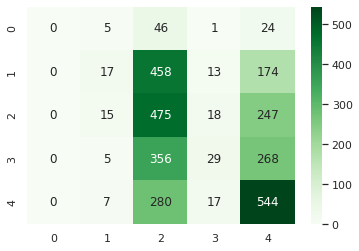

In [ ]:
cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, annot=True, cmap="Greens", fmt = 'd')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.35      0.03      0.05       662
           2       0.29      0.63      0.40       755
           3       0.37      0.04      0.08       658
           4       0.43      0.64      0.52       848

    accuracy                           0.36      2999
   macro avg       0.29      0.27      0.21      2999
weighted avg       0.35      0.36      0.27      2999



A acurácia geral é de 38%, sendo o melhor resultado para esse desafio 46%.

Como já haviamos notado, a análise sentimental tende a não ser tão precisa e acaba não tendo uma grande influência na adoção. Muitas das "notas" dadas a partir da análise de sentimentos são influenciadas por palavras contidas na descrição que não necessariamente estavam direcionadas ao animal. 

In [ ]:
train_2.loc[train_2['compound']==-.981600,['Description']].values

array([['Meet Baby Rosemary, one of the puppies that we intend to rescue out from the area where they hv been seeking shelter since born - longkang near the surau. We recently found out that the timid mummy that we have been feeding actually gave birth to 7 puppies, but roughly 2 weeks ago, one heartless human being took one stick & jolok the hole near longkang where the puppies have been seeking refuge. And with that 3 was killed. Such a sad thing isnt that such hatred still exist? Why have to kill these innocent puppies? Moving on, we hope to get the 2 remaining puppies soon. They are kinda protective & barks loudly when touch. Who doesnt if they are subject to constant harassment & abuse like the dead siblings, rite?']],
      dtype=object)

A descrição desse animal não fala mal do próprio, mas por contar uma "história" de maldade e de morte, utilizando palavras fortes como, **kill, killed, hatred**, etc, acabou que influenciou o modelo a aumentar muito o conceito negativo da descrição e resultando na "pior descrição" da base inteira.